In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Imports and Setup

In [18]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../src")

from strategy import Strategy
from backtest import run_backtest

# 2. Load and clean data

In [3]:
# Load your BTC/USD hourly data
data_path = '../data/btc_hour.csv'
df = pd.read_csv(data_path)
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,2011-11-28 00:00:00+00:00,2.499,2.461,2.480,3457.45,8571.74,2.497,direct,NaN
1,2011-11-28 01:00:00+00:00,2.498,2.480,2.497,681.46,1698.15,2.498,direct,NaN
2,2011-11-28 02:00:00+00:00,2.499,2.485,2.498,624.29,1559.13,2.487,direct,NaN
3,2011-11-28 03:00:00+00:00,2.498,2.442,2.487,2648.16,6519.05,2.442,direct,NaN
4,2011-11-28 04:00:00+00:00,2.500,2.440,2.442,4299.98,10667.19,2.462,direct,NaN


In [4]:
df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,2011-11-28 00:00:00+00:00,2.499,2.461,2.480,3457.45,8.571740e+03,2.497,direct,NaN
1,2011-11-28 01:00:00+00:00,2.498,2.480,2.497,681.46,1.698150e+03,2.498,direct,NaN
2,2011-11-28 02:00:00+00:00,2.499,2.485,2.498,624.29,1.559130e+03,2.487,direct,NaN
3,2011-11-28 03:00:00+00:00,2.498,2.442,2.487,2648.16,6.519050e+03,2.442,direct,NaN
4,2011-11-28 04:00:00+00:00,2.500,2.440,2.442,4299.98,1.066719e+04,2.462,direct,NaN
...,...,...,...,...,...,...,...,...,...
118054,2025-05-16 22:00:00+00:00,103649.830,103450.360,103643.590,978.41,1.012609e+08,103551.320,direct,NaN
118055,2025-05-16 23:00:00+00:00,103718.440,103465.470,103551.320,312.40,3.235507e+07,103499.600,direct,NaN
118056,2025-05-17 00:00:00+00:00,103569.600,103141.310,103499.600,488.11,5.044067e+07,103388.020,direct,NaN
118057,2025-05-17 01:00:00+00:00,103388.090,102642.390,103388.020,669.72,6.891526e+07,102859.210,direct,NaN


In [5]:
# Data cleaning: keep only time, close, volumeto; cast time to datetime; rename volumeto to volume
df = df[['time', 'close', 'volumeto']].copy()
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'volumeto': 'volume'})
df.head()

,time,close,volume
0,2011-11-28 00:00:00+00:00,2.497,8571.74
1,2011-11-28 01:00:00+00:00,2.498,1698.15
2,2011-11-28 02:00:00+00:00,2.487,1559.13
3,2011-11-28 03:00:00+00:00,2.442,6519.05
4,2011-11-28 04:00:00+00:00,2.462,10667.19


In [6]:
df.tail()

,time,close,volume
118054,2025-05-16 22:00:00+00:00,103551.32,1.012609e+08
118055,2025-05-16 23:00:00+00:00,103499.60,3.235507e+07
118056,2025-05-17 00:00:00+00:00,103388.02,5.044067e+07
118057,2025-05-17 01:00:00+00:00,102859.21,6.891526e+07
118058,2025-05-17 02:00:00+00:00,103307.02,2.715254e+07


# 3. Define strategy

### Buy and Hold strategy

In [7]:
from strategies import BuyAndHoldStrategy, SMACrossoverStrategy

# class BuyAndHoldStrategy(Strategy):
#     def __init__(self, initial_capital=10000):
#         super().__init__(initial_capital)
#         self.has_bought = False

#     def process_bar(self, bar):
#         self.current_bar = bar

#     def get_signal(self):
#         if not self.has_bought:
#             self.has_bought = True
#             return 'buy'
#         return 'hold'

### SMA Crossover Strategy

In [8]:
# class SMACrossoverStrategy(Strategy):
#     def __init__(self, initial_capital=10000, fast=20, slow=100):
#         super().__init__(initial_capital)
#         self.prices = []
#         self.fast = fast
#         self.slow = slow
#         self.last_signal = 'hold'

#     def process_bar(self, bar):
#         self.current_bar = bar
#         self.prices.append(bar['close'])
#         if len(self.prices) < self.slow:
#             self.last_signal = 'hold'
#             return

#         fast_ma = pd.Series(self.prices).rolling(self.fast).mean().iloc[-1]
#         slow_ma = pd.Series(self.prices).rolling(self.slow).mean().iloc[-1]

#         if fast_ma > slow_ma and self.position == 0:
#             self.last_signal = 'buy'
#         elif fast_ma < slow_ma and self.position == 1:
#             self.last_signal = 'sell'
#         else:
#             self.last_signal = 'hold'

#     def get_signal(self):
#         return self.last_signal

# 4. Run Backtests

In [9]:
bt_df = df.copy().head(20000)

# Buy and Hold
bh_results = run_backtest(BuyAndHoldStrategy, bt_df, initial_capital=10000)

# SMA Crossover
sma_results = run_backtest(
    lambda initial_capital: SMACrossoverStrategy(initial_capital, fast=20, slow=100),
    bt_df,
    initial_capital=10000
)

# 5. Compare Results

In [10]:
def print_metrics(name, results):
    print(f"--- {name} ---")
    print(f"Sharpe Ratio: {results['sharpe']:.2f}")
    print(f"Total Return: {results['total_return']*100:.2f}%")
    print(f"Annualized Return: {results['annualized_return']*100:.2f}%")
    print(f"Max Drawdown: {results['max_drawdown']*100:.2f}%")
    print(f"Number of Trades: {results['n_trades']}")
    print(f"Win Rate: {results['win_rate']*100:.2f}%")
    print()

print_metrics("Buy & Hold", bh_results)
print_metrics("SMA Crossover", sma_results)

--- Buy & Hold ---
Sharpe Ratio: 3.13
Total Return: 25007.07%
Annualized Return: 1025.03%
Max Drawdown: 79.13%
Number of Trades: 1
Win Rate: 100.00%

--- SMA Crossover ---
Sharpe Ratio: 2.22
Total Return: 298.98%
Annualized Return: 83.33%
Max Drawdown: 96.62%
Number of Trades: 166
Win Rate: 48.19%



NameError: name 'np' is not defined

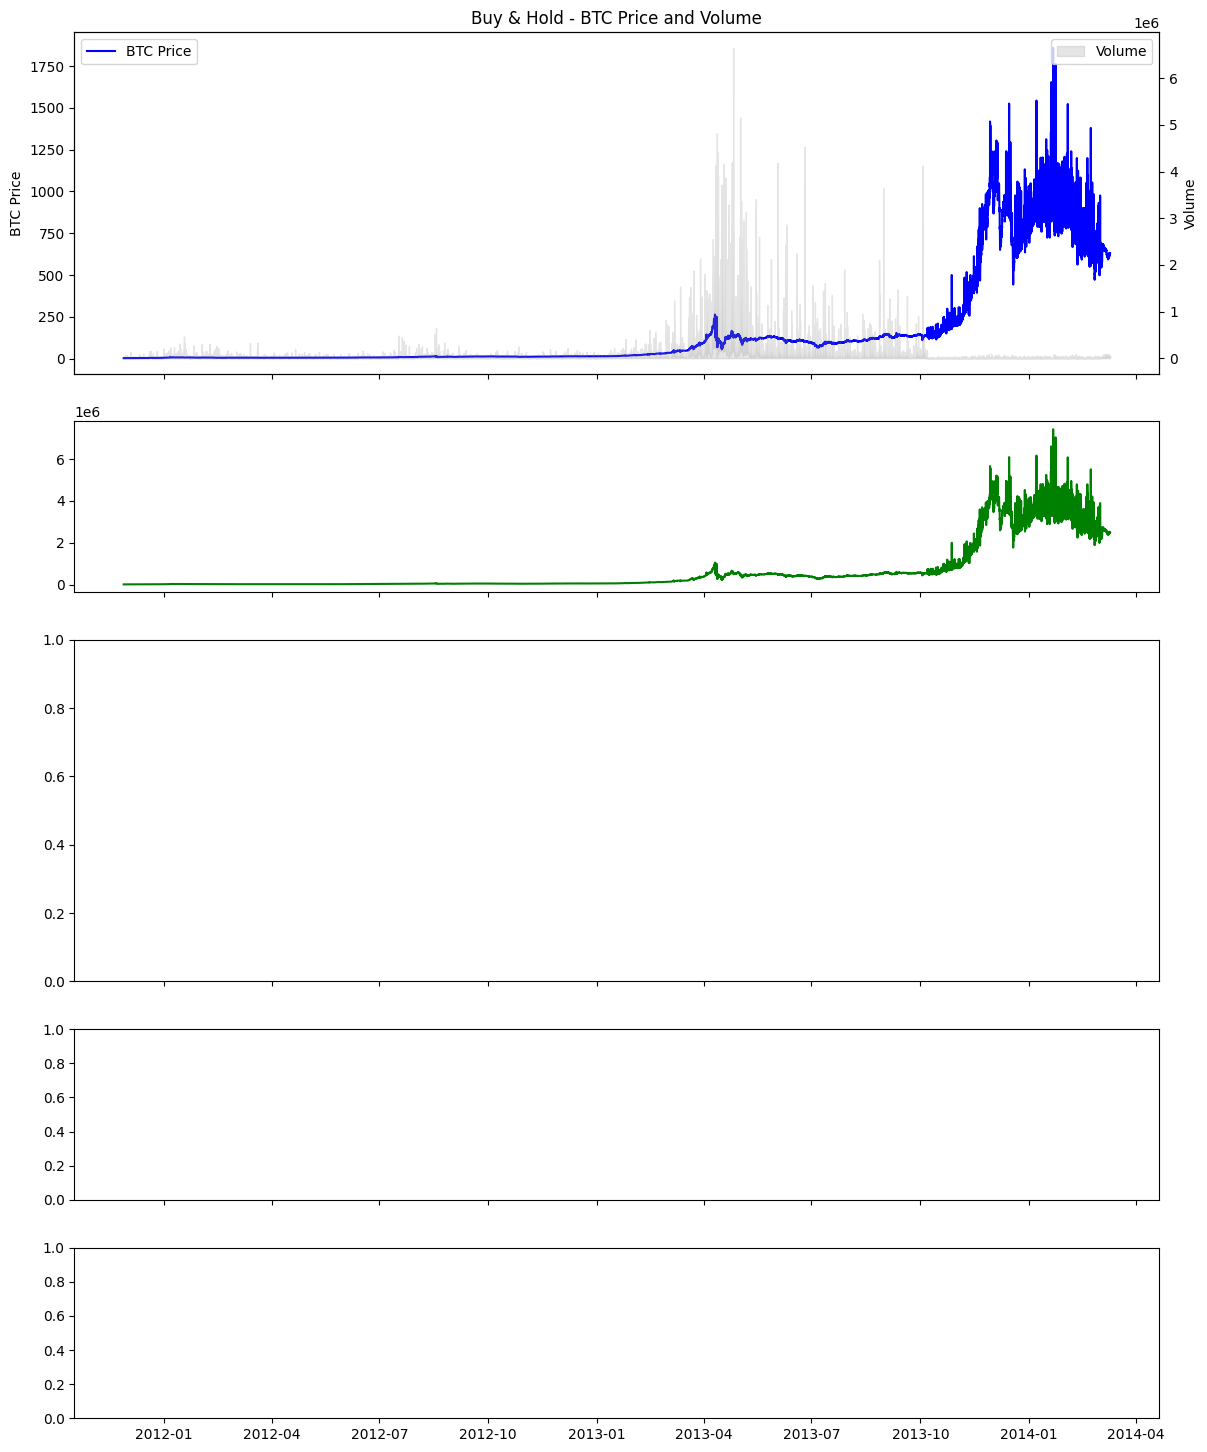

In [11]:
import matplotlib.dates as mdates
import numpy as np

def plot_strategy_results(df, results, name="Strategy"):
    # Align index for plotting
    times = pd.to_datetime(df['time'])
    equity = results['equity_curve'].reset_index(drop=True)
    rolling_sharpe = results['rolling_sharpe'].reset_index(drop=True)
    unrealized_dd = results['unrealized_drawdown'].reset_index(drop=True)
    realized_dd = results['realized_drawdown'].reset_index(drop=True)

    fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [2, 1, 2, 1, 1]})

    # 1. Price and Volume
    axs[0].plot(times, df['close'], label='BTC Price', color='blue')
    ax2 = axs[0].twinx()
    ax2.fill_between(times, df['volume'], color='gray', alpha=0.2, label='Volume')
    axs[0].set_ylabel('BTC Price')
    ax2.set_ylabel('Volume')
    axs[0].set_title(f"{name} - BTC Price and Volume")
    axs[0].legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 2. Equity Curve with r^2
    axs[1].plot(times, equity[:len(times)], label='Equity Curve', color='green')
    
    # Add linear regression line
    if 'r_squared' in results and 'slope' in results and 'intercept' in results:
        x = np.arange(len(times))
        y_pred = results['slope'] * x + results['intercept']
        axs[1].plot(times, y_pred[:len(times)], 'r--', 
                   label=f'Trend (R²: {results["r_squared"]:.2f})')
    
    axs[1].set_ylabel('Equity ($)')
    axs[1].set_title(f"{name} - Equity Curve")
    axs[1].legend()
    axs[1].grid(True)

    # 3. Drawdown
    axs[2].plot(times, unrealized_dd[:len(times)], label='Unrealized Drawdown', color='red')
    axs[2].plot(times, realized_dd[:len(times)], label='Realized Drawdown', color='orange', linestyle='--', marker='o', markersize=3)
    axs[2].set_ylabel('Drawdown')
    axs[2].set_title(f"{name} - Drawdown")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Rolling Sharpe
    axs[3].plot(times, rolling_sharpe[:len(times)], label='Rolling Sharpe (30d)', color='purple')
    axs[3].set_ylabel('Sharpe')
    axs[3].set_title(f"{name} - Rolling Sharpe Ratio")
    axs[3].legend()
    axs[3].grid(True)

    # 5. Trades (Buy/Sell markers)
    axs[4].plot(times, df['close'], color='blue', alpha=0.5)
    # Only keep indices that are within the bounds of df/times
    buys = [idx for idx in [t['entry_idx'] for t in results['trades']] if idx < len(df)]
    sells = [idx for idx in [t['exit_idx'] for t in results['trades']] if idx < len(df)]

    axs[4].scatter(times.iloc[buys], df['close'].iloc[buys], marker='^', color='green', label='Buy', zorder=5)
    axs[4].scatter(times.iloc[sells], df['close'].iloc[sells], marker='v', color='red', label='Sell', zorder=5)
    axs[4].set_ylabel('BTC Price')
    axs[4].set_title(f"{name} - Buy/Sell Points")
    axs[4].legend()
    axs[4].grid(True)

    # X-axis formatting
    axs[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_strategy_results(bt_df, bh_results, name="Buy & Hold")
plot_strategy_results(bt_df, sma_results, name="SMA Crossover")

---

# To do right now
 - [ ] Make our backtest more efficient / faster

---
---

In [14]:
sys.path.append("..")

from scripts.test_strategy import test_strategy
dev, holdout = test_strategy("../src/strategies/template.py", return_results=True)
print(dev)
print(holdout)

{'sharpe': 0.0, 'total_return': np.float64(0.0), 'n_trades': 0, 'win_rate': 0.0, 'max_drawdown': np.float64(0.0), 'annualized_return': np.float64(0.0), 'equity_curve': 0         10000.0
1         10000.0
2         10000.0
3         10000.0
4         10000.0
           ...   
114764    10000.0
114765    10000.0
114766    10000.0
114767    10000.0
114768    10000.0
Length: 114769, dtype: float64, 'trades': [], 'rolling_sharpe': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
114764    0.0
114765    0.0
114766    0.0
114767    0.0
114768    0.0
Length: 114769, dtype: float64, 'unrealized_drawdown': 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
114764    0.0
114765    0.0
114766    0.0
114767    0.0
114768    0.0
Length: 114769, dtype: float64, 'realized_drawdown': 0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
114764   NaN
114765   NaN
114766   NaN
114767   NaN
114768   NaN
Length: 114

In [16]:
holdout

{'sharpe': 0.0,
 'total_return': np.float64(0.0),
 'n_trades': 0,
 'win_rate': 0.0,
 'max_drawdown': np.float64(0.0),
 'annualized_return': np.float64(0.0),
 'equity_curve': 114792    10000.0
 114793    10000.0
 114794    10000.0
 114795    10000.0
 114796    10000.0
            ...   
 118054    10000.0
 118055    10000.0
 118056    10000.0
 118057    10000.0
 118058    10000.0
 Length: 3267, dtype: float64,
 'trades': [],
 'rolling_sharpe': 114792    0.0
 114793    0.0
 114794    0.0
 114795    0.0
 114796    0.0
          ... 
 118054    0.0
 118055    0.0
 118056    0.0
 118057    0.0
 118058    0.0
 Length: 3267, dtype: float64,
 'unrealized_drawdown': 114792    0.0
 114793    0.0
 114794    0.0
 114795    0.0
 114796    0.0
          ... 
 118054    0.0
 118055    0.0
 118056    0.0
 118057    0.0
 118058    0.0
 Length: 3267, dtype: float64,
 'realized_drawdown': 114792   NaN
 114793   NaN
 114794   NaN
 114795   NaN
 114796   NaN
           ..
 118054   NaN
 118055   NaN
 11805